In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pickle

#%matplotlib notebook
%matplotlib widget 

In [2]:
flat_list = np.genfromtxt('./flat/flat.list', dtype=str)
print(flat_list)

['AF580626.fits' 'AF580627.fits' 'AF580628.fits' 'AF580629.fits'
 'AF580630.fits' 'AF580631.fits' 'AF580632.fits' 'AF580633.fits'
 'AF580634.fits' 'AF580635.fits' 'AF580636.fits' 'AF580637.fits'
 'AF580638.fits' 'AF580639.fits' 'AF580640.fits' 'AF580641.fits'
 'AF580642.fits' 'AF580643.fits' 'AF580644.fits' 'AF580645.fits'
 'AF580646.fits' 'AF580647.fits' 'AF580648.fits' 'AF580649.fits'
 'AF580650.fits' 'AF580651.fits' 'AF580652.fits' 'AF580653.fits'
 'AF580654.fits' 'AF580655.fits']


In [3]:
median_bias = pickle.load(open("./median_bias.p", "rb"))
bias_std = 1.31 # [e] photoelectrons
readout_noise = 7.10  # [e] photoelectrons
gain = 1.91 # [e/ADU]

In [4]:
flat_fits = fits.open('./flat/'+flat_list[0])
flat_data = flat_fits[0].data * gain

print('CCD Gain         : {0:4.2f} {1:.8s}'.format(flat_fits[0].header['GAIN'],flat_fits[0].header.comments['GAIN']))
print('CCD Readout noise: {0:4.2f} {1:.3s}'.format(flat_fits[0].header['RDNOISE'],flat_fits[0].header.comments['RDNOISE']))
print('Shape of the FITS image from the header : {0:4d} x {1:4d} pixels'.format(flat_fits[0].header['NAXIS1'], flat_fits[0].header['NAXIS2']))

CCD Gain         : 1.91 [e/ADU] 
CCD Readout noise: 7.10 [e]
Shape of the FITS image from the header :  521 x  222 pixels


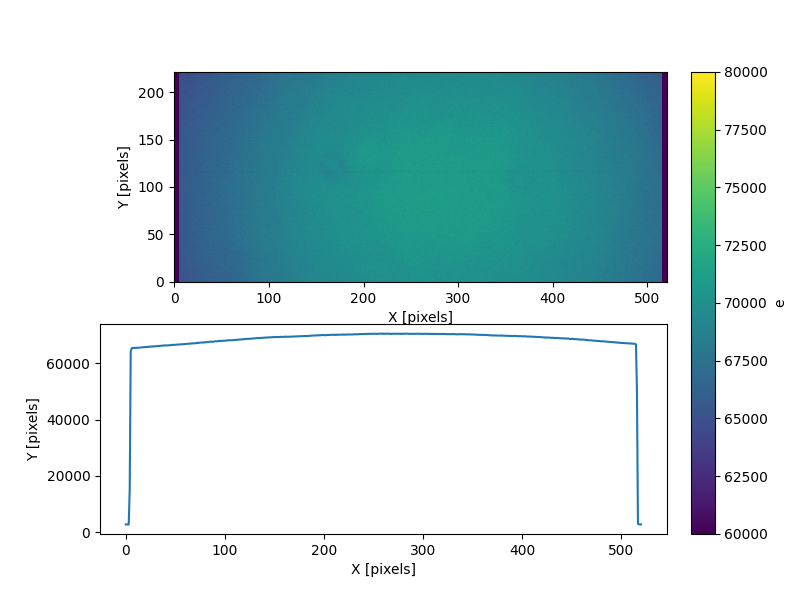

In [5]:
fig, ax = plt.subplots(2,1, figsize=(8,6)) 
im1 = ax[0].imshow(flat_data, vmin = 60000, vmax = 80000, origin='lower')
median_column = np.average(flat_data, axis=0)
im2 = ax[1].plot(median_column)

cbar = fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("e")

ax[0].set_xlabel('X [pixels]')
ax[0].set_ylabel('Y [pixels]')

ax[1].set_xlabel('X [pixels]')
ax[1].set_ylabel('Y [pixels]')
plt.show()

### Removing Overscan

In [7]:
vmin = np.amin(flat_data[:, 12:-12])
vmax = np.amax(flat_data[:, 12:-12])
print(vmin, vmax)

64086.229999999996 72035.65


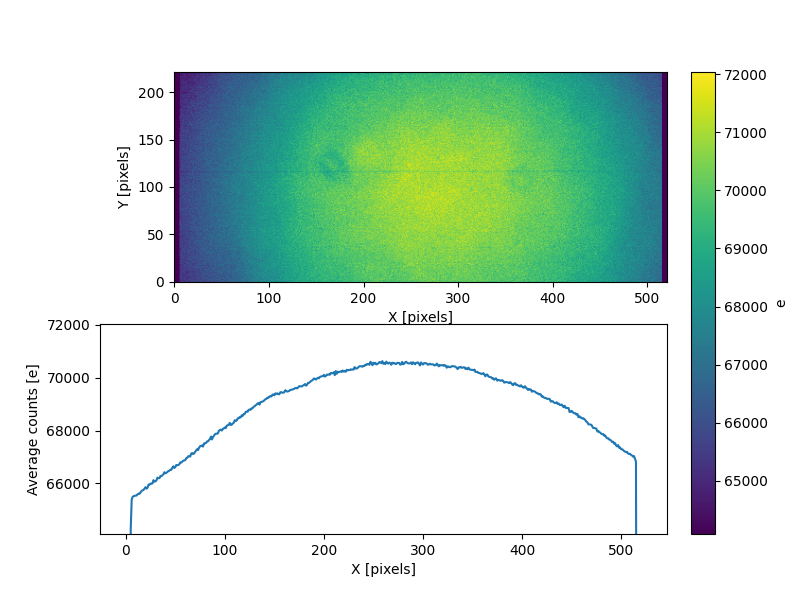

In [8]:
fig, ax = plt.subplots(2,1, figsize=(8,6)) 
im1 = ax[0].imshow(flat_data, origin='lower', vmin=vmin, vmax=vmax)
median_column = np.average(flat_data, axis=0)
im2 = ax[1].plot(median_column)

ax[1].set_ylim(vmin,vmax)

# add the colorbar using the figure's method,
# telling which mappable we're talking about and
# which axes object it should be near
cbar = fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("e")

ax[0].set_xlabel('X [pixels]')
ax[0].set_ylabel('Y [pixels]')

ax[1].set_xlabel('X [pixels]')
ax[1].set_ylabel('Average counts [e]')
plt.show()

### Computing Normalizing Factors

Read frames one by one, correcting for bias, and store in the flat.

In [9]:
n_images = len(flat_list)
flat_array_dim0, flat_array_dim1 = np.shape(flat_data)

stack = np.empty([n_images, flat_array_dim0, flat_array_dim1])

for i_flat, flat_name in enumerate(flat_list):
    flat_temp = fits.open('./flat/'+flat_name)
    stack[i_flat,:,:] = flat_temp[0].data * flat_temp[0].header['GAIN'] - median_bias
    flat_temp.close()

Compensating for any non-uniformity in the response of the CCD to light.

We are interested in how the pixels interact with each other - we can express the flat correction as the correction value relative to the median response over a selected sample of pixels

In [10]:
windows_size = 50
# x0, x1, y0, y1 are the four corners
x0 = np.int16(flat_array_dim1/2 - windows_size/2)
x1 = np.int16(flat_array_dim1/2 + windows_size/2)
y0 = np.int16(flat_array_dim0/2 - windows_size/2)
y1 = np.int16(flat_array_dim0/2 + windows_size/2)

print('Coordinates of the box: x0:{0}, x1:{1}, y0:{2}, y1:{3}'.format(x0, x1, y0, y1))

Coordinates of the box: x0:235, x1:285, y0:86, y1:136


The median will be calculated using all the values in the range `[y0:y1, x0:x1]` of each frame.

In [11]:
normalization_factors = np.median(stack[:,y0:y1, x0:x1], axis=(1,2))
print('Number of normalization factors (must be the same as the number of frames): {0}'.format(np.shape(normalization_factors)))
print(normalization_factors)

Number of normalization factors (must be the same as the number of frames): (30,)
[68196.55   68455.355  68250.03   68366.54   68187.955  68451.0575
 68229.02   68429.0925 68293.96   68442.4625 68285.8425 68463.4725
 68244.7775 68437.6875 68240.48   68450.58   68311.15   68443.895
 68294.915  68372.27   68269.6075 68486.87   68321.655  68464.4275
 68322.1325 68500.24   68280.59   68482.095  68287.275  68507.88  ]


This is not the correct way to propagate the errors. **Do I have to fix?**

In [12]:
normalization_factors_std = np.std(stack[:,y0:y1, x0:x1], axis=(1,2)) / np.sqrt(windows_size**2)
print(normalization_factors_std)

[6.49091374 6.30964692 6.60702319 6.56209055 6.22337822 6.55573255
 6.44091275 6.31735704 6.35890937 6.51668595 6.35521015 6.57674396
 6.43997908 6.36791648 6.52908989 6.51365307 6.47945835 6.46205774
 6.51784036 6.46543194 6.48377755 6.61794633 6.22881265 6.96689115
 6.40031612 6.45330486 6.48532881 6.37159746 6.57106562 6.34137309]


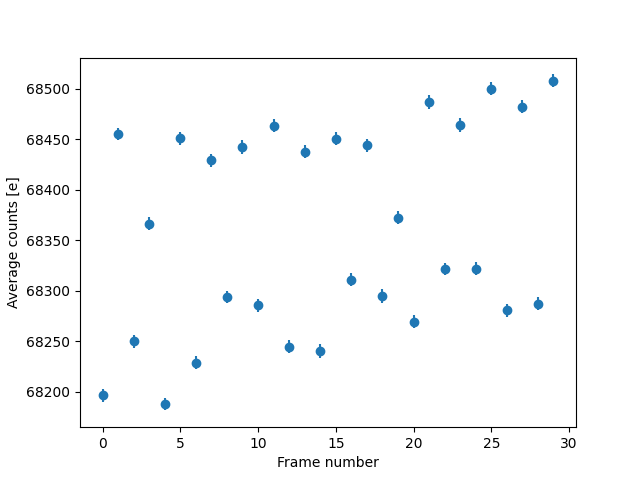

In [13]:
plt.figure()
x_frame = np.arange(0,n_images, 1)
plt.scatter(x_frame, normalization_factors)
plt.errorbar(x_frame, normalization_factors, normalization_factors_std, fmt='o', ms=2)
plt.xlabel('Frame number')
plt.ylabel('Average counts [e]')
plt.show()

### Flat Normalization

Iterate along the frame and correct by normalization factors:

In [14]:
stack_normalized_iter =  stack * 0. #initialization of the output array
for i_flat in range(n_images):
    stack_normalized_iter[i_flat,:,:] = stack[i_flat,:,:] / normalization_factors[i_flat]

Or by using broadcasting:

In [15]:
print("shape of stack array           : ", np.shape(stack))
print("shape of transposed stack array: ", np.shape(stack.T))

stack_normalized = (stack.T / normalization_factors).T

print("shape of normalized stack array: ", np.shape(stack_normalized))

shape of stack array           :  (30, 222, 521)
shape of transposed stack array:  (521, 222, 30)
shape of normalized stack array:  (30, 222, 521)


In [16]:
print("Maximum absolute difference between the two arrays: {0:2.6e}".format(np.max(np.abs(stack_normalized_iter-stack_normalized))))

Maximum absolute difference between the two arrays: 0.000000e+00


In [17]:
print(np.finfo(float).eps)

2.220446049250313e-16


These two methods produce the same results, to the best computer accuracy.

### Computing Median Flat Frame

In [18]:
median_normalized_flat = np.median(stack_normalized, axis=0)

pickle.dump(median_normalized_flat, open("median_normalized_flat.p", "wb")) 
pickle.dump(stack_normalized, open("flat_normalized_stack.p", "wb")) 
pickle.dump(normalization_factors, open("flat_normalization_factors.p", "wb")) 
pickle.dump(stack, open("flat_stack.p", "wb")) 

64086.229999999996 72035.65


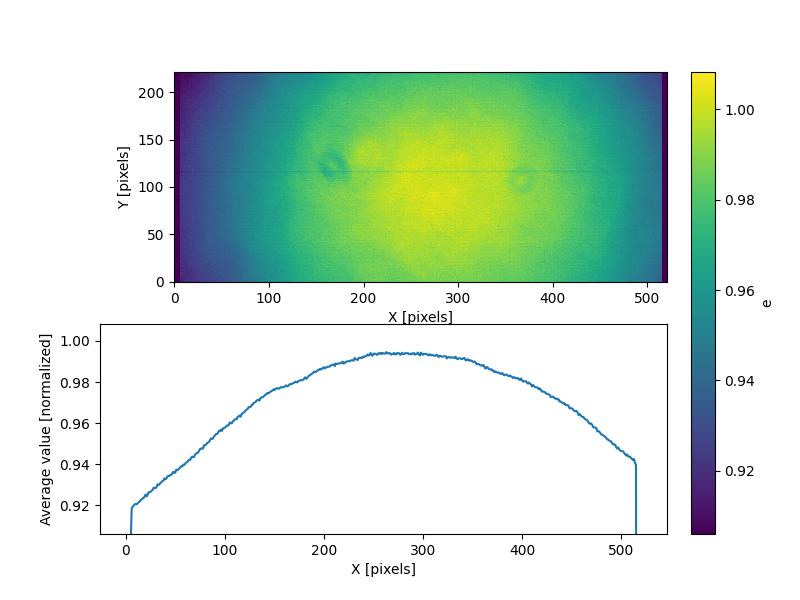

In [19]:
i_image = 0
nmin = np.amin(median_normalized_flat[:, 12:-12])
nmax = np.amax(median_normalized_flat[:, 12:-12])
print(vmin, vmax)


fig, ax = plt.subplots(2,1, figsize=(8,6)) # Caution, figsize will also influence positions.
im1 = ax[0].imshow(median_normalized_flat, origin='lower', vmin=nmin, vmax=nmax)
median_column = np.average(median_normalized_flat, axis=0)
im2 = ax[1].plot(median_column)

# we set the plot limits 
ax[1].set_ylim(nmin,nmax)

# add the colorbar using the figure's method,
# telling which mappable we're talking about and
# which axes object it should be near
cbar = fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("e")

ax[0].set_xlabel('X [pixels]')
ax[0].set_ylabel('Y [pixels]')

ax[1].set_xlabel('X [pixels]')
ax[1].set_ylabel('Average value [normalized]')
plt.show()

### Error Propagation

Errors in flat frames:
1. the readout noise
2. the error associated with the median bias frame
3. the photon noise associated with the flux of the lamp

We already have an estimate of the error from the first two due to our bias analysis.

In [20]:
#photon_noise = np.sqrt(stack)
photon_noise = np.sqrt(np.abs(stack))

In [21]:
stack_error = np.sqrt(readout_noise **2 + bias_std**2 +  photon_noise**2)

In [22]:
stack_normalized_error = (stack_error.T/normalization_factors).T 

In [23]:
median_normalized_flat_errors = np.sqrt(np.sum(stack_normalized_error**2, axis=0)) / n_images
print("shape of the median normalized error array: ", np.shape(median_normalized_flat_errors))
pickle.dump(median_normalized_flat_errors, open("median_normalized_flat_errors.p", "wb")) 

shape of the median normalized error array:  (222, 521)


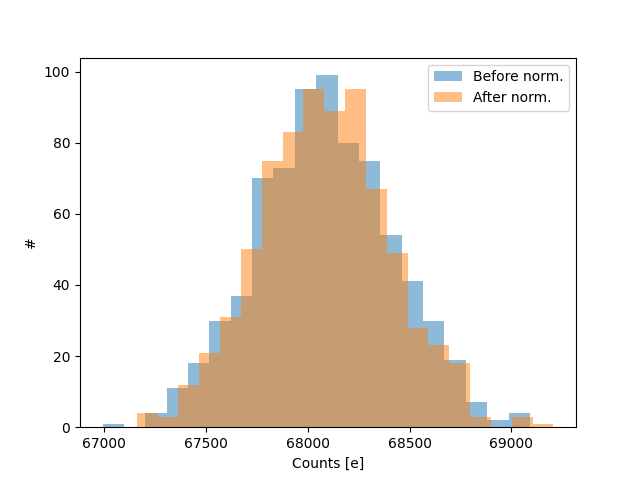

In [24]:
mean_normalization = np.mean(normalization_factors)

plt.figure()
plt.hist(stack[:,40:45,250:255].flatten(), bins=20, alpha=0.5, label='Before norm.')
plt.hist(stack_normalized[:,40:45,250:255].flatten()*mean_normalization, bins=20, alpha=0.5, label='After norm.')
plt.xlabel('Counts [e]')
plt.ylabel('#')
plt.legend()
plt.show()

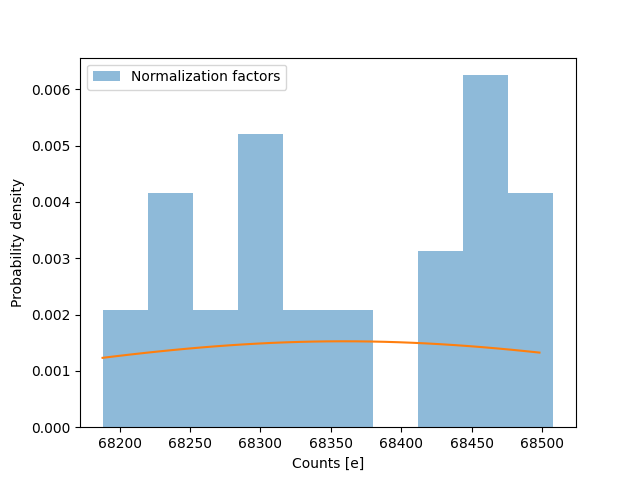

In [25]:
sigma_mean_normalization = np.sqrt(mean_normalization)
x = np.arange(np.amin(normalization_factors), np.amax(normalization_factors), 10)
y = 1./(sigma_mean_normalization * np.sqrt(2 * np.pi)) * \
               np.exp( - (x - mean_normalization)**2 / (2 * sigma_mean_normalization**2) )

plt.figure()
plt.hist(normalization_factors,alpha=0.5, density=True, label='Normalization factors')
plt.plot(x,y)
plt.xlabel('Counts [e]')
plt.ylabel('Probability density')
plt.legend()
plt.show()
